In [83]:
import cv2
import argparse
import numpy as np
import os.path
import math
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
def imshow(tit, image) :
    plt.title(tit)
    if len(image.shape) == 3 :
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else :
        plt.imshow(image, cmap="gray")
    plt.show()

In [3]:
# Initialize the parameters
confThreshold = 0.5  #Confidence threshold
nmsThreshold = 0.4   #Non-maximum suppression threshold 가까운 것은 한 개로 보겠다.
inpWidth = 416       #Width of network's input image  얘는 무조건 정해진 사이즈임
inpHeight = 416      #Height of network's input image  얘는 무조건 정해진 사이즈임

# Load names of classes
classesFile = "../2020.01.28/coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')
print(classes)
# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = "../2020.01.28/yolov3.cfg"
modelWeights = "../2020.01.28/yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


## 아래 셀에 대한 부연설명

- net.getUnconnectedOutLayers()을 print하면 [[200], [227], [254]] 이 나옴
- 그럼 왜 [i[0] - 1] for i in net.getUnconnectedOutLayers()에서 -1을 해줘야 할까?
- net.getUnconnectedOutLayers()을 print하면 [[200], [227], [254]] 이 나옴
- net.getUnconnectedOutLayers()은 레이어 번호를 1부터 시작함... 근데 파이썬의 index는 0부터 시작하니까!

In [20]:
l = net.getLayerNames()
print(l)
print(len(l))
print('\n')

print(net.getUnconnectedOutLayers())


layersNames = net.getLayerNames()
print([layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()])

# net.getUnconnectedOutLayers()을 print하면 [[200], [227], [254]] 이 나옴
# 그럼 왜 [i[0] - 1] for i in net.getUnconnectedOutLayers()에서 -1을 해줘야 할까?
# net.getUnconnectedOutLayers()을 print하면 [[200], [227], [254]] 이 나옴
# net.getUnconnectedOutLayers()은 레이어 번호를 1부터 시작함... 근데 파이썬의 index는 0부터 시작하니까!

print(layersNames[199])
print(layersNames[226])
print(layersNames[253])

['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn_38', 're

In [29]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), 
                  (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]    # 이미지 높이
    frameWidth = frame.shape[1]   # 이미지 너비

    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            scores = detection[5:]  # 확률 80개를 모두 가져옴
            classId = np.argmax(scores) # 80개 확률값 중에서 가장 높은 것의 index값을 가져오기
            confidence = scores[classId]
            if confidence > confThreshold:
                center_x = int(detection[0] * frameWidth)
                center_y = int(detection[1] * frameHeight)
                width = int(detection[2] * frameWidth)
                height = int(detection[3] * frameHeight)
                left = int(center_x - width / 2)
                top = int(center_y - height / 2)
                classIds.append(classId)
                confidences.append(float(confidence))
                boxes.append([left, top, width, height])

    # Perform non-maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.   # 같은 classId이고 가까우면 같은 객체로 보기 위해 다음과 같이 설정
    print(len(boxes))
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    
    print(indices)
    
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]   # w
        height = box[3]   # h
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

(576, 768, 3)
(1, 3, 416, 416)
3
[[2]
 [1]
 [0]]


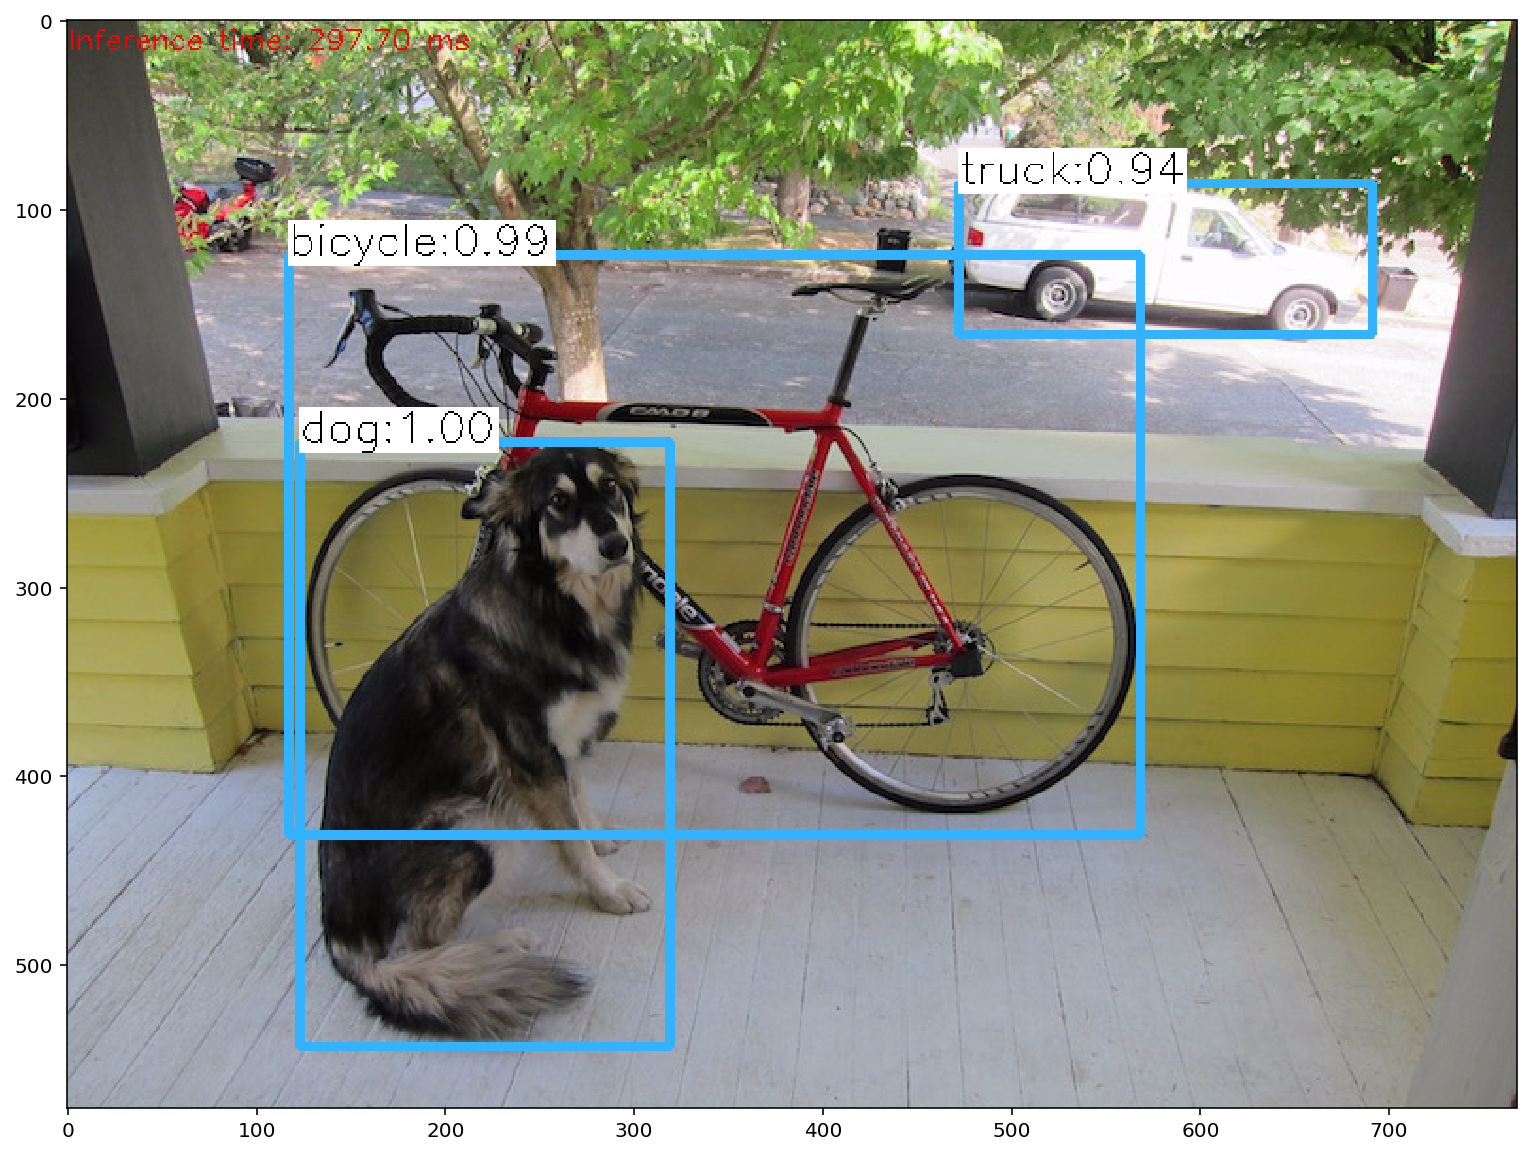

True

In [91]:
cap = cv2.VideoCapture('../2020.01.28/dog2.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.

print(frame.shape)
blob = cv2.dnn.blobFromImage(frame, 1/255, # frame은 BGR 채널 # 1/255는 normalize시킨 것(scalefactor)
                             (inpWidth, inpHeight), 
                             [0,0,0], # 평균을 의미함
                             1, # SwapRB옵션으로 1또는 True이면 R채널과 B채널을 바꾸고 0,False이면 안바꿈
                             crop=False)
print(blob.shape)  # 여기선 SwapRB옵션을 실행해서 blob는 RGB채널임
net.setInput(blob) # 입력정보를 흘려줌(train data를 보낸다고 생각하면 됌)

outs = net.forward(getOutputsNames(net)) # net.forward('레이어명')->레이어 선택

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

fig=plt.figure(figsize=(20,10))
imshow("",frame)
plt.show()
cv2.imwrite("out.jpg", frame) 
# img = cv.cvtColor(frame, cv.COLOR_BGR2RGB)



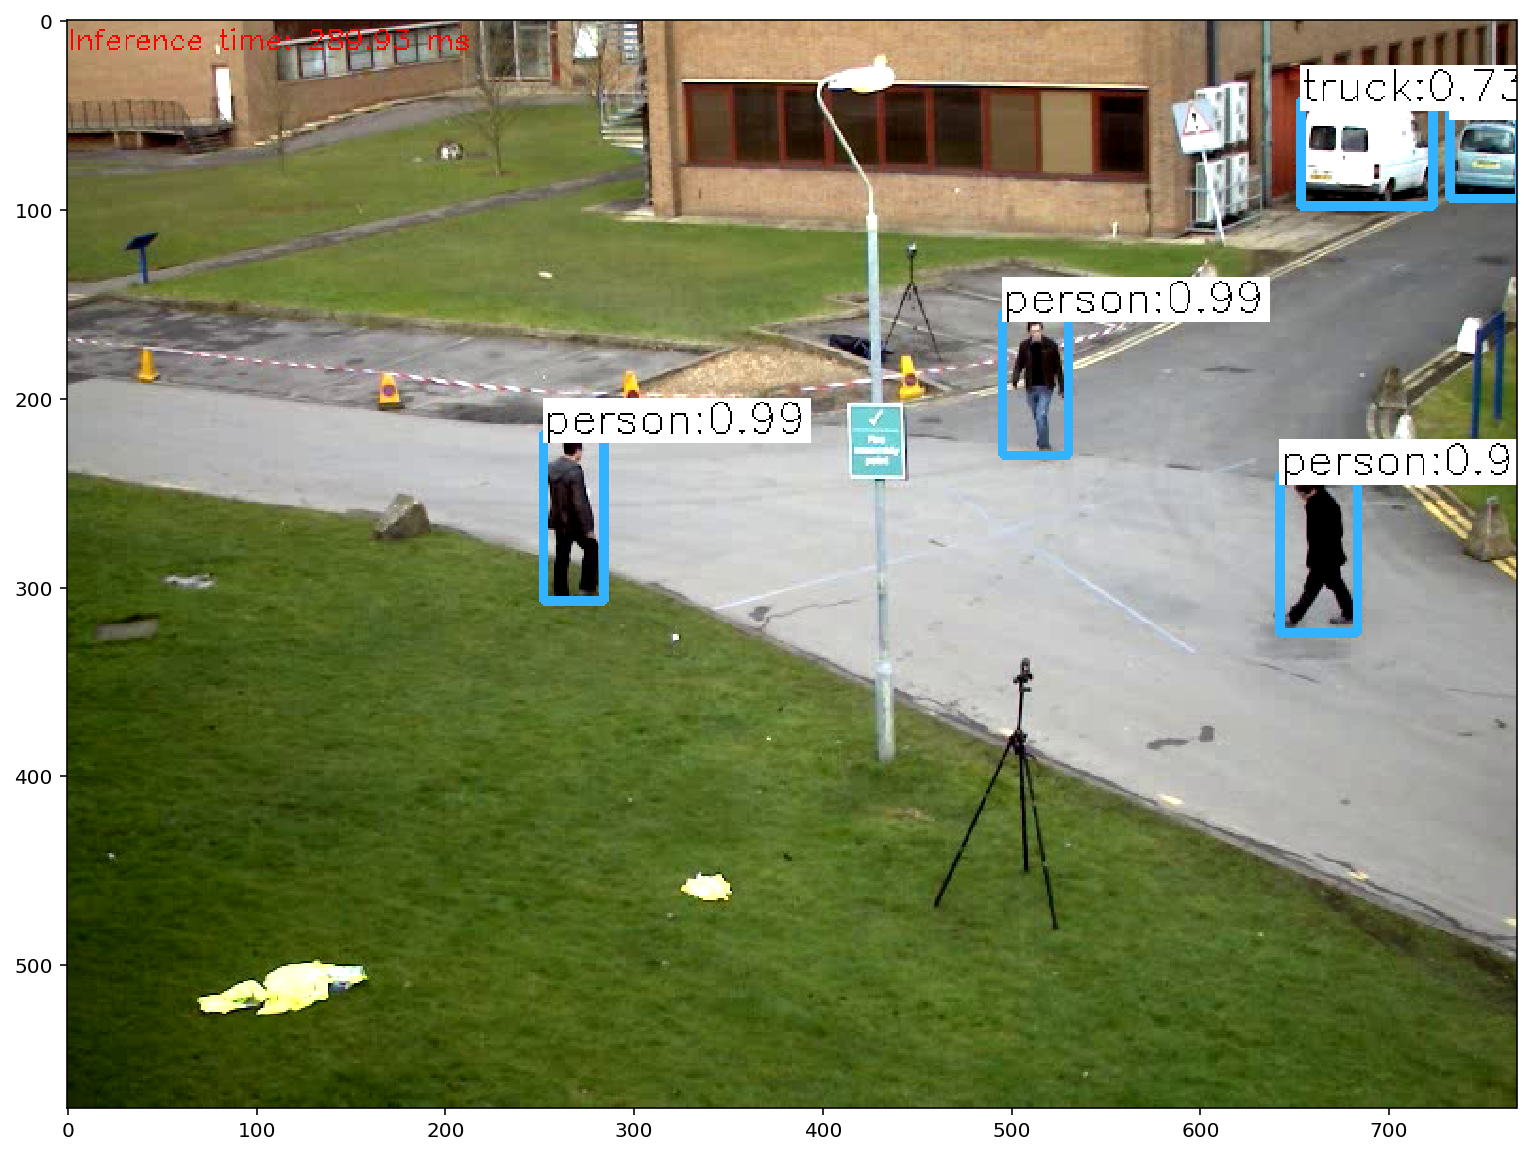

True

In [20]:
cap = cv2.VideoCapture('vtest.avi')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

fig=plt.figure(figsize=(20,10))
imshow("",frame)
plt.show()
cv2.imwrite("out2.jpg", frame) 

In [30]:
cap = cv2.VideoCapture('cars.jpg')

hasFrame, frame = cap.read()

#inpWidth =  frame.shape[1]
#inpHeight = frame.shape[0]
# 여기서 inpWidth는 영상의 크기가 아님.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

net.setInput(blob)

outs = net.forward(getOutputsNames(net))

In [27]:
print(type(outs))
print(len(outs))
print(outs[0].shape)    # yolo layer 1 0번째 box   13*13*3
print(outs[1].shape)     #    26*26*3
print(outs[2].shape)     # 52*52*3

print(outs[0][0])

<class 'list'>
3
(507, 85)
(2028, 85)
(8112, 85)
[4.9900591e-02 3.2529898e-02 2.2278704e-01 2.2572391e-01 4.2922568e-07
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00

In [28]:
# 위의 postprocess로 정의한 함수를 이해해보기 위해서 출력해보는 연습을 함
detection = outs[0][0]
scores = detection[5:]
print(scores)
classId = np.argmax(scores)
print(classId)
confidence = scores[classId]

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]
0


12
[[ 6]
 [ 5]
 [ 4]
 [ 2]
 [ 0]
 [ 3]
 [ 8]
 [10]
 [11]
 [ 1]
 [ 9]]


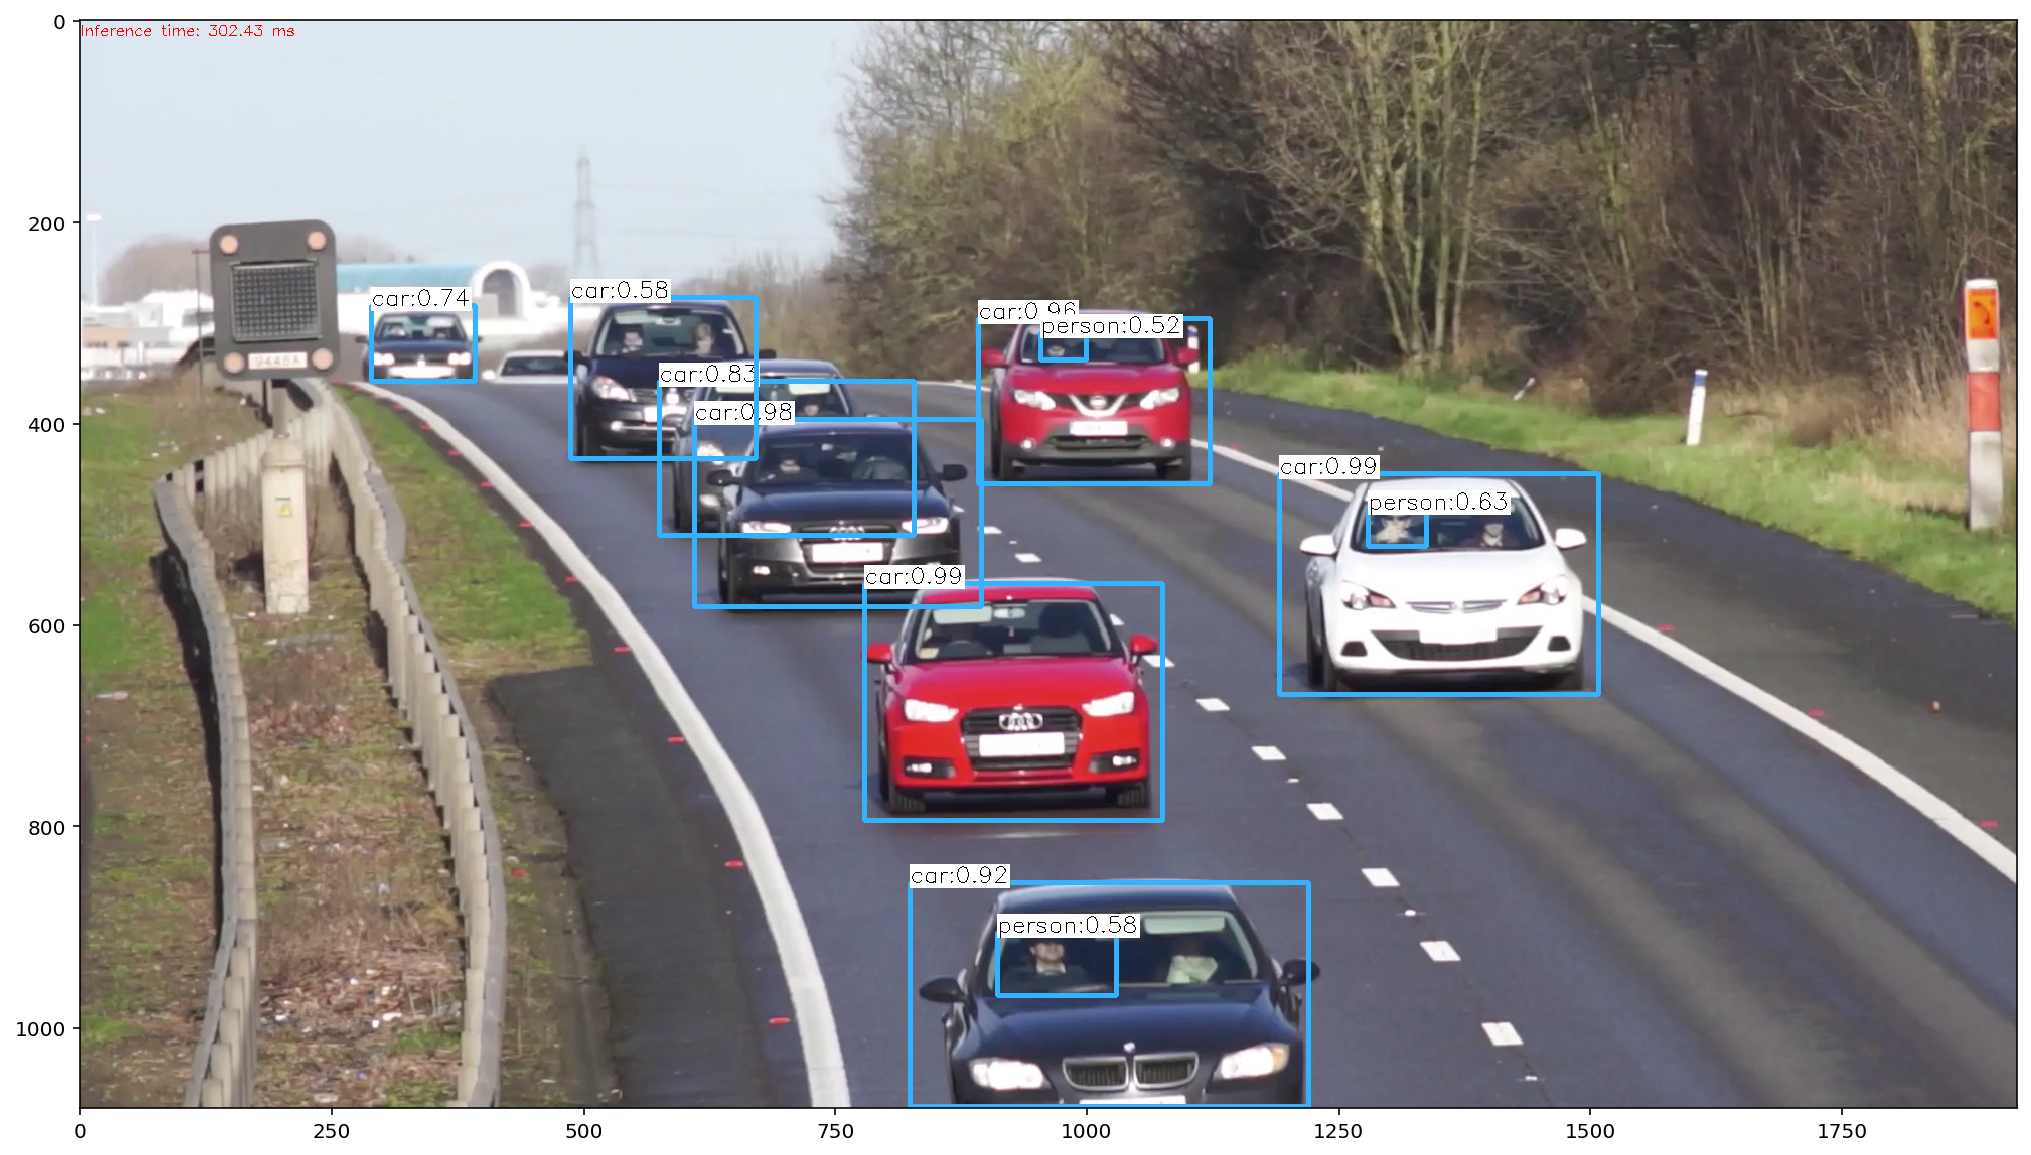

True

In [31]:
postprocess(frame, outs)

t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

fig=plt.figure(figsize=(20,10))
imshow("",frame)
plt.show()
cv2.imwrite("out2.jpg", frame) 

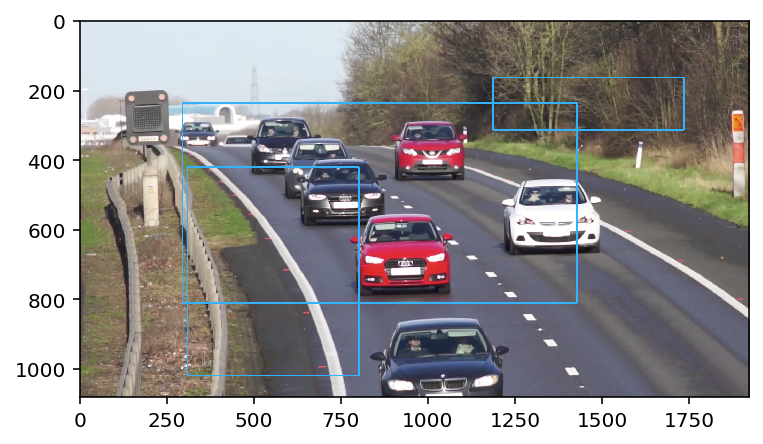

In [85]:
frame = cv2.imread('cars.jpg')
frameHeight = frame.shape[0]    # 이미지 높이
frameWidth = frame.shape[1]   # 이미지 너비

yolo = net.forward("yolo_82")

for i in range(len(yolo)) :
    detection = yolo[i]
    scores = detection[5:]  # 확률 80개를 모두 가져옴
    classId = np.argmax(scores) # 80개 확률값 중에서 가장 높은 것의 index값을 가져오기
    confidence = scores[classId]
    if confidence > 0.01:
        center_x = int(detection[0] * frameWidth)
        center_y = int(detection[1] * frameHeight)
        width = int(detection[2] * frameWidth)
        height = int(detection[3] * frameHeight)
        left = int(center_x - width / 2)
        right = int(center_x + width / 2)
        top = int(center_y - height / 2)
        bottom = int(center_y + height / 2)
        cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
        
#         classIds.append(classId)
#         confidences.append(float(confidence))
#         boxes.append([left, top, width, height])
imshow("", frame)
plt.show()



# center_x = int(detection[0] * frameWidth)
# center_y = int(detection[1] * frameHeight)
# width = int(detection[2] * frameWidth)
# height = int(detection[3] * frameHeight)
# left = int(center_x - width / 2)
# right = int(center_x + width / 2)
# top = int(center_y - height / 2)
# bottom = int(center_y + height / 2)
# Box = [left, top, width, height]

# cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)

# fig=plt.figure(figsize=(15,8))
# imshow("",frame)
# plt.show()

---

### 이런 그림을 만들어주기 위한 첫 걸음
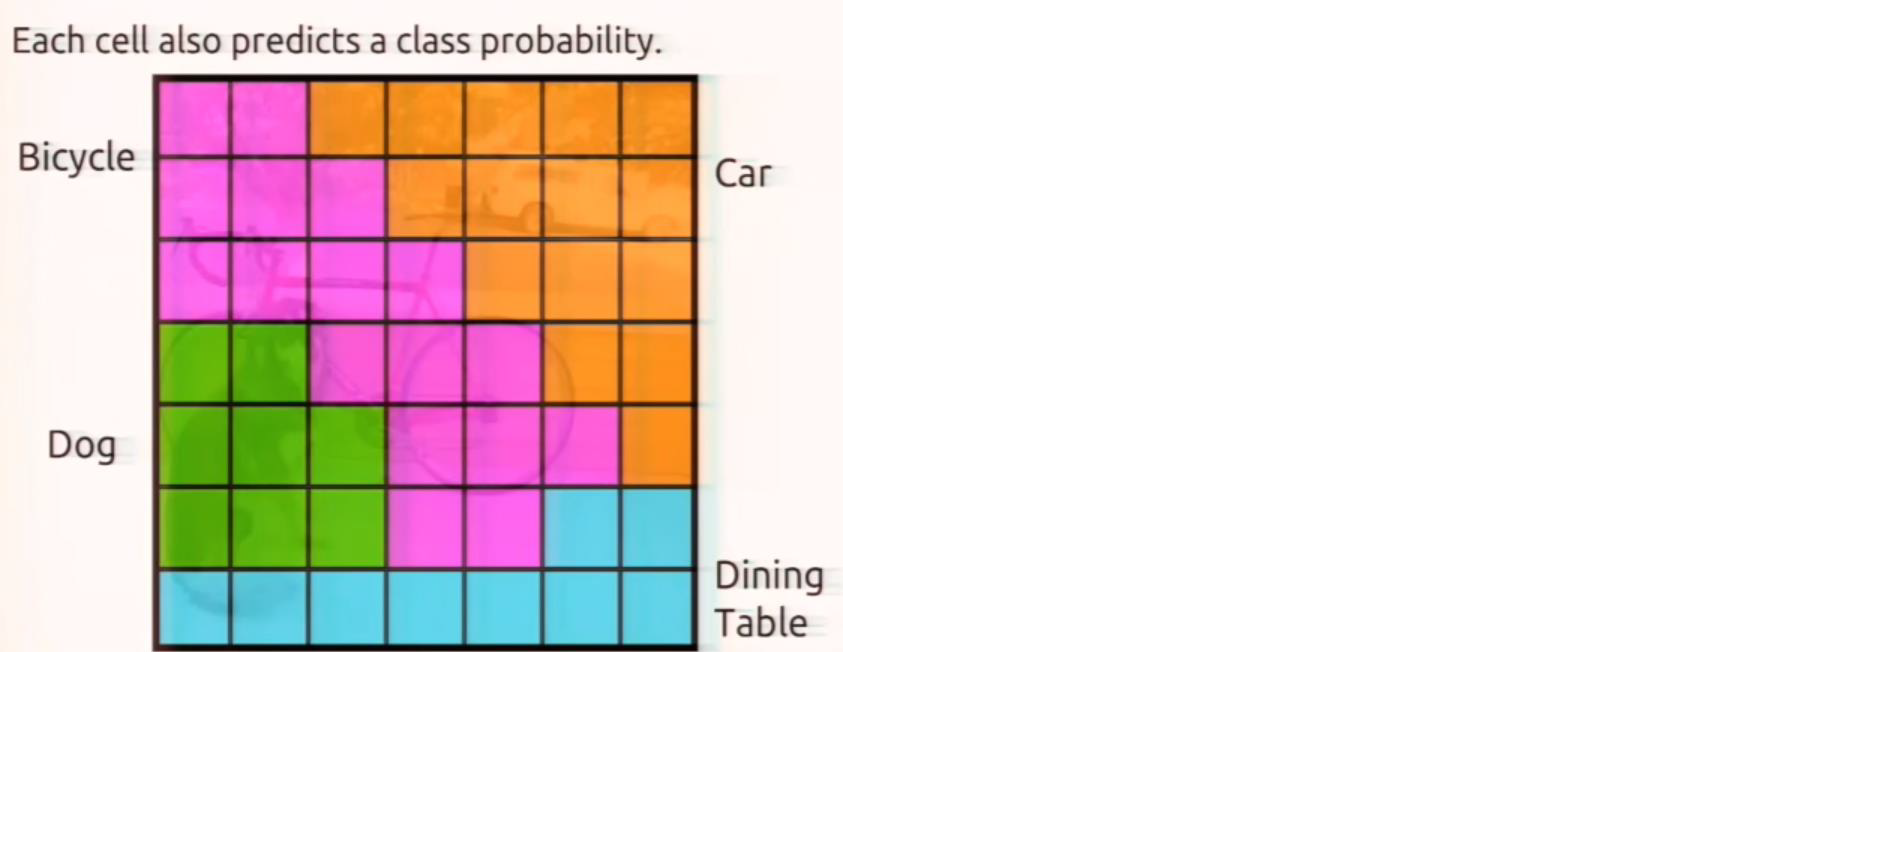

In [92]:
print(yolo.shape)

(507, 85)


In [88]:
cells = []

for i in range(len(yolo)):
    detection = yolo[i]
    scores = detection[5:]  
    classId = np.argmax(scores)
    confidence = scores[classId]
    if confidence > 0.01:
        cells.append(classId+1)
    else :
        cells.append(0)

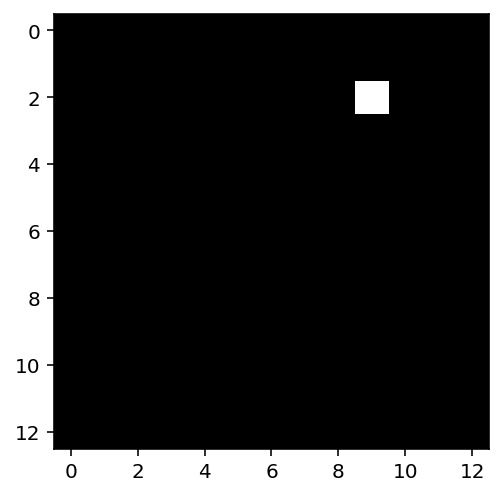

In [89]:
cells = np.array(cells)
s  = int(math.sqrt(len(yolo)/3))

cells = cells.reshape(s,s,3)

img = cells[:,:,0]*30 # 30을 곱해준 이유는 그림에서 색 차이를 극명하게 나타내려고

imshow("", img)
plt.show()

---

## 동영상 만들기

In [95]:
# function을 정의할 때 *의 역할 이해
def fun(a,b,c):
    print(a)
    print(b)
    print(c)
fun(1,2,3)
print('\n')
fun(*[1,2,3])
print('\n')
print(*"123")

1
2
3


1
2
3


1 2 3


In [107]:
import cv2
import time
img = cv2.imread("../2020.01.28/book1.jpg")

fourcc = cv2.VideoWriter_fourcc(*"XVID") # 동영상마다 코덱을 써줌
video = cv2.VideoWriter("out3.avi", fourcc, 20.0, (img.shape[1], img.shape[0]))

for i in range(100):
    video.write(img)
    time.sleep(0.01)

# img1 = cv2.imread("../2020.01.28/book1.jpg")
# out.write(img1)

# img1 = cv2.imread("../2020.01.28/book2.jpg")
# out.write(img1)

# img1 = cv2.imread("../2020.01.28/book3.jpg")
# out.write(img1)

# img1 = cv2.imread("../2020.01.28/book4.jpg")
# out.write(img1)

video.release()

### 밑에 셀은 미완성 코드이므로 실행시키지 말 것!

In [105]:
import cv2
import time

cap = cv2.VideoCapture('../2020.01.28/vtest.avi')

fourcc = cv2.VideoWriter_fourcc(*"XVID") # 동영상마다 코덱을 써줌
video = cv2.VideoWriter("vtest_out.avi", fourcc, 20.0, (576,768))

for i in range(30):
    ret, frame = cap.read()
    blob = cv2.dnn.blobFromImage(frame, 1/255, 
                             (inpWidth, inpHeight), 
                             [0,0,0],
                             1,
                             crop=False)
    net.setInput(blob)
    outs = net.forward(getOutputsNames(net)) # net.forward('레이어명')->레이어 선택
    postprocess(frame, outs)
    video.write(frame)
    time.sleep(0.01)

video.release()

9
[[2]
 [3]
 [4]
 [6]
 [1]]
8
[[2]
 [3]
 [4]
 [6]
 [1]]
8
[[2]
 [3]
 [4]
 [6]
 [1]]
8
[[3]
 [4]
 [6]
 [2]
 [1]]
9
[[4]
 [3]
 [7]
 [6]
 [1]
 [8]]
8
[[4]
 [3]
 [6]
 [2]
 [1]]
8
[[2]
 [3]
 [4]
 [6]
 [1]]
9
[[2]
 [3]
 [4]
 [6]
 [1]]
9
[[4]
 [3]
 [2]
 [6]
 [1]]
9
[[4]
 [2]
 [3]
 [6]
 [1]
 [7]]
9
[[2]
 [3]
 [4]
 [7]
 [1]
 [5]]
9
[[3]
 [2]
 [8]
 [7]
 [5]
 [1]]
9
[[4]
 [3]
 [7]
 [2]
 [5]
 [1]]
10
[[4]
 [3]
 [5]
 [2]
 [7]
 [1]
 [9]]
10
[[5]
 [2]
 [4]
 [3]
 [7]
 [1]]
9
[[4]
 [3]
 [5]
 [2]
 [7]
 [1]]
10
[[4]
 [5]
 [3]
 [7]
 [2]
 [1]
 [9]]
9
[[3]
 [2]
 [4]
 [7]
 [8]
 [5]
 [1]]
10
[[2]
 [3]
 [4]
 [7]
 [8]
 [5]
 [1]]
9
[[2]
 [4]
 [7]
 [3]
 [5]
 [1]]
9
[[2]
 [4]
 [3]
 [5]
 [7]
 [1]]
9
[[2]
 [4]
 [3]
 [7]
 [5]
 [1]]
9
[[2]
 [4]
 [7]
 [5]
 [8]
 [1]]
11
[[ 4]
 [ 7]
 [ 5]
 [ 3]
 [ 8]
 [ 0]
 [10]]
10
[[5]
 [4]
 [7]
 [2]
 [0]
 [8]
 [3]]
9
[[5]
 [7]
 [2]
 [4]
 [3]
 [0]
 [8]]
8
[[4]
 [6]
 [3]
 [2]
 [7]
 [1]]
8
[[3]
 [4]
 [6]
 [2]
 [7]
 [1]]
7
[[3]
 [4]
 [6]
 [2]
 [0]]
8
[[3]
 [4]
 [6]
 [2]
 [0]]
